In [1]:
import os
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
#import anndata as ad
import scanpy as sc
import matplotlib.colors as mcolors
now_path=os.getcwd()
data_path=now_path+'\\..\\raw data\\'

In [ ]:
def extract_gene_name_from_index(index_str):
    """从索引字符串中提取基因名"""
    # 格式: '10023_ZC3H18_P1P2_ENSG00000158545'
    parts = index_str.split('_')
    if len(parts) >= 2:
        return parts[1]  # 基因名是第二部分
    else:
        return index_str

In [ ]:
file='K562_essential_normalized_bulk_01.h5ad'
file2='K562_gwps_normalized_bulk_01.h5ad'
file3='rpe1_normalized_bulk_01.h5ad'
K_e_n_b_adata=sc.read_h5ad(data_path+file)
K_g_n_b_adata=sc.read_h5ad(data_path+file2)
R_e_n_b_adata=sc.read_h5ad(data_path+file3)
K_e_n_b_adata.obs['target']=[extract_gene_name_from_index(idx) for idx in K_e_n_b_adata.obs.index]
K_g_n_b_adata.obs['target']=[extract_gene_name_from_index(idx) for idx in K_g_n_b_adata.obs.index]
R_e_n_b_adata.obs['target']=[extract_gene_name_from_index(idx) for idx in R_e_n_b_adata.obs.index]

d:\Anaconda\envs\scRNA\lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\Anaconda\envs\scRNA\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


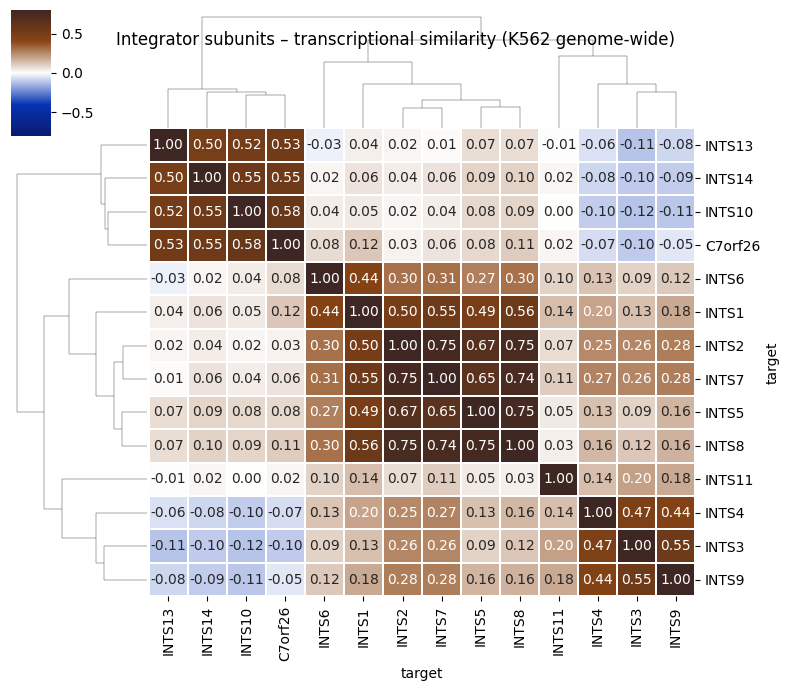

In [ ]:

# 强扰动筛选（论文标准）
mask = (K_g_n_b_adata.obs['anderson_darling_counts'] >= 50) & \
       (K_g_n_b_adata.obs['target'] != 'non-targeting') & \
       (K_g_n_b_adata.obs['num_cells_unfiltered'] >= 25) & \
       (K_g_n_b_adata.obs['pct_expr'] <= -0.3)          # ≥30% knockdown

strong = K_g_n_b_adata[mask].copy()

# 高变基因筛选（同论文 2319 个）
strong.var['cv'] = strong.X.std(axis=0) / strong.X.mean(axis=0)
mask_hvg = (strong.var['clean_mean'] > 0.25) & (strong.var['cv'].notna())
strong_hvg = strong[:, mask_hvg].copy()
top_genes = strong_hvg.var['cv'].sort_values(ascending=False).head(2319).index
strong_hvg = strong_hvg[:, top_genes].copy()

# 去 inf & 转 df
X = strong_hvg.X
X[~np.isfinite(X)] = 0
strong_hvg.X = X
df = strong_hvg.to_df()
df.index = strong_hvg.obs['target']
df.columns = strong_hvg.var['gene_name']

# 同一 Symbol 合并（防重复）
df = df.groupby(df.index).mean()

# 相关矩阵
corr = df.T.corr(method='pearson')

# Integrator 成员
integrator = ['INTS1','INTS2','INTS3','INTS4','INTS5','INTS6',
              'INTS7','INTS8','INTS9','INTS10','INTS11','INTS12',
              'INTS13','INTS14','C7orf26']
int_idx = [g for g in integrator if g in corr.index]
int_corr = corr.loc[int_idx, int_idx]

# 自定义 colormap -0.8 ~ 0.8
colors = [ '#0A1A6E','#0633B4','#FFFFFF','#8B4513','#3E2723']
cmap = mcolors.LinearSegmentedColormap.from_list('brown_blue', colors, N=256)
norm = mcolors.Normalize(vmin=-0.8, vmax=0.8)

# 画 clustermap
g = sns.clustermap(
    int_corr,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    norm=norm,
    square=True,
    linewidths=0.3,
    tree_kws={'linewidths': 0.3},
    cbar_kws={"shrink": .6},
    figsize=(8, 7)
)
g.fig.suptitle('Integrator subunits – transcriptional similarity (K562 genome-wide)', y=0.95)
#g.fig.savefig('../figures/fig3B_K562_Integrator_modules.png', dpi=300)
plt.show()

In [ ]:

df = df.groupby(df.index).mean()   # 确保 Symbol 唯一

In [ ]:
import torch

d:\Anaconda\envs\scRNA\lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\Anaconda\envs\scRNA\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


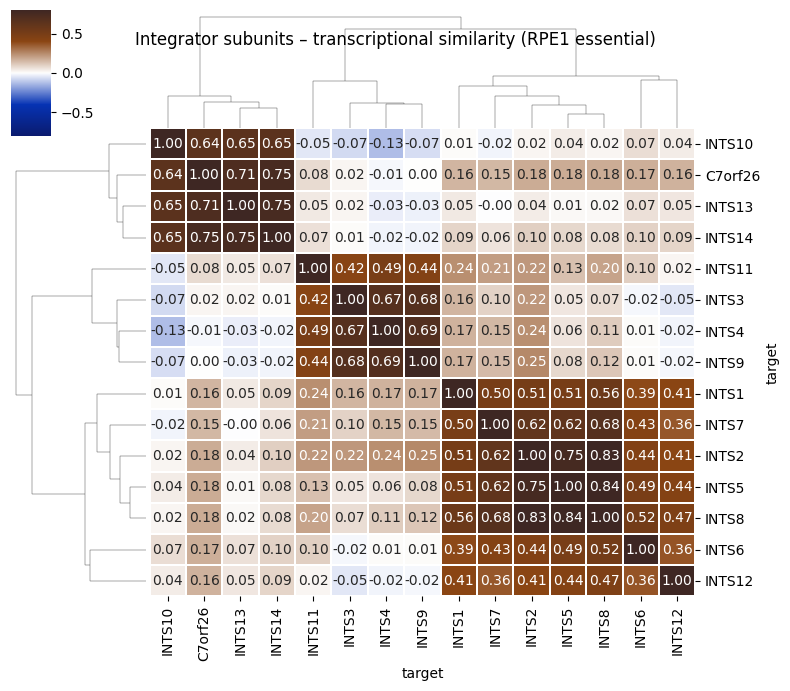

In [ ]:
# 读取 RPE1 essential bulk
rpe_adata = sc.read_h5ad(os.path.join(data_path, file3))

# 提取 gene Symbol
def extract_gene_name(index_str):
    parts = index_str.split('_')
    return parts[1] if len(parts) >= 2 else index_str

rpe_adata.obs['target'] = [extract_gene_name(i) for i in rpe_adata.obs.index]

# 强扰动筛选（同论文标准）
mask = (rpe_adata.obs['anderson_darling_counts'] >= 50) & \
       (rpe_adata.obs['target'] != 'non-targeting') & \
       (rpe_adata.obs['pct_expr'] <= -0.3)
strong = rpe_adata[mask].copy()

# 高变基因 2319 个
strong.var['cv'] = strong.X.std(axis=0) / strong.X.mean(axis=0)
mask_hvg = (strong.var['clean_mean'] > 0.25) & (strong.var['cv'].notna())
strong_hvg_rep = strong[:, mask_hvg].copy()
top_genes = strong_hvg_rep.var['cv'].sort_values(ascending=False).head(2319).index
strong_hvg_rep = strong_hvg_rep[:, top_genes].copy()

# 去 inf & 转 df
X = strong_hvg_rep.X
X[~np.isfinite(X)] = 0
strong_hvg_rep.X = X
df = strong_hvg_rep.to_df()
df.index = strong_hvg_rep.obs['target']
df.columns = strong_hvg_rep.var['gene_name']

# 同一 Symbol 合并（关键去重）
df = df.groupby(df.index).mean()

# 相关矩阵
corr = df.T.corr(method='pearson')

# Integrator 成员
integrator = ['INTS1','INTS2','INTS3','INTS4','INTS5','INTS6',
              'INTS7','INTS8','INTS9','INTS10','INTS11','INTS12',
              'INTS13','INTS14','C7orf26']
int_idx = [g for g in integrator if g in corr.index]
int_corr = corr.loc[int_idx, int_idx]

# 自定义 colormap -0.8 ~ 0.8（同 K562）
colors = ['#0A1A6E','#0633B4','#FFFFFF','#8B4513','#3E2723']
cmap = mcolors.LinearSegmentedColormap.from_list('brown_blue', colors, N=256)
norm = mcolors.Normalize(vmin=-0.8, vmax=0.8)

# 画 clustermap
g = sns.clustermap(
    int_corr,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    norm=norm,
    square=True,
    linewidths=0.3,
    tree_kws={'linewidths': 0.3},
    cbar_kws={"shrink": .6},
    figsize=(8, 7)
)
g.fig.suptitle('Integrator subunits – transcriptional similarity (RPE1 essential)', y=0.95)
#g.fig.savefig('../figures/fig3B_RPE1_Integrator_modules.png', dpi=300)
plt.show()